# Predicting Los Angeles Traffic with Graphical Neural Networks
Originally by Julie Wang, Amelia Woodward, Tracy Cai

Remodelled by David Gerard to use DGL instead of Pytorch Geometric and include additional visualizations

Original Github: https://github.com/jswang/cs224w_traffic_prediction  
Original Paper: https://ieeexplore.ieee.org/document/8903252

## Setup

In [1]:
import dgl
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
print(f"Version {torch.__version__}")
print(f"Version {dgl.__version__}")

Using cpu
Version 2.4.1
Version 2.4.0+cu124


Set random seeds for reproducability.

In [2]:
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

In [3]:
import importlib
import models.trainer
importlib.reload(models.trainer)

model_dir, runs_dir = models.trainer.setup_directories("Predicting_LA_Traffic")

## Start training

Now with all code in place, let's set up config, load our dataset, and start training! Set up the tensorboard to visualize training runs.

In [13]:
%load_ext tensorboard
%tensorboard --logdir {runs_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3606567), started 0:08:53 ago. (Use '!kill 3606567' to kill it.)

Now, create your dataloaders and start training!

In our default configuration, we train for 60 epochs with a batch size of 50. You can view your training progress in the tensorboard above by clicking the "refresh" button to see new data. Training and validation performance are updated every 5 epochs.

In [ ]:
from dgl.dataloading import GraphDataLoader
import os
import importlib
import pandas as pd

import dataloader.la_traffic_dataloader
import dataloader.splits
import models.st_gat
import models.trainer
import models.persist

## Reload module in case any changes were made
importlib.reload(dataloader.la_traffic_dataloader)
importlib.reload(dataloader.splits)
importlib.reload(models.st_gat)
importlib.reload(models.trainer)
importlib.reload(models.persist)

RETRAIN = True
SAVE_MODEL = True
SAVE_ATTENTION = True

config = {
    'BATCH_SIZE': 50,
    'EPOCHS': 60,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'CHECKPOINT_DIR': runs_dir,
    'N_PRED': 9,
    'N_HIST': 12,
    'DROPOUT': 0.2,
    # number of possible 5 minute measurements per day
    'N_DAY_SLOT': 288,
    # number of days worth of data in the dataset
    'N_DAYS': 44,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 228,
    'FULLY_CONNECTED': False
}

dataset, config['D_MEAN'], config['D_STD_DEV'], d_train, d_val, d_test = dataloader.la_traffic_dataloader.get_processed_dataset(config)
test_dataloader = GraphDataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)

model_path = f'{model_dir}/model.pth'
attn_path = f'{model_dir}/attention.pth'

attn_matrices_by_batch_by_epoch = None

if SAVE_ATTENTION:
    epochs_for_saving_attn = [0, config['EPOCHS'] // 2, config['EPOCHS'] - 1]
else:
    epochs_for_saving_attn = []

if os.path.exists(model_path) and os.path.exists(attn_path) and not RETRAIN:
    print(f"Model found at {model_path}, loading the saved model instead of training.")
    model = models.st_gat.ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
    model.load_state_dict(torch.load(model_path, weights_only=True))
    print(f"Loading the saved attention matrices found at {attn_path}.")
    attn_matrices_by_batch_by_epoch = torch.load(attn_path)
else:
    train_dataloader = GraphDataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
    val_dataloader = GraphDataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)

    # Configure and train model
    config['N_NODE'] = dataset.graphs[0].number_of_nodes()
    model, attn_matrices_by_batch_by_epoch = models.trainer.model_train(train_dataloader, val_dataloader, config, device, epochs_for_saving_attn)

    if SAVE_ATTENTION:
        # Save the tensor to a file
        torch.save(attn_matrices_by_batch_by_epoch, attn_path)
    if SAVE_MODEL:
        # Save the trained model
        models.persist.save_model(model, model_path)

Completed Data Preprocessing


Epoch 0: 100%|██████████| 183/183 [02:35<00:00,  1.18it/s]


Loss: 0.336
Train, MAE: 5.431145668029785, RMSE: 8.75970458984375, MAPE: 14.538707733154297
Valid, MAE: 5.337759971618652, RMSE: 8.47816276550293, MAPE: 14.163618087768555
Model saved to ./trained_models/Predicting_LA_Traffic/model.pth


## Test the model

Now that we have a trained model, we can test it on the test dataset and visualize its performance. This first code cell is for visualizing the attention matrices with a heat map. The second cell is to visualize the matrices as weighted edges in a graph.

In [17]:
# Run inference on the test data
_, _, _, y_pred, y_truth, _ = models.trainer.eval(model, device, test_dataloader, config, 'Test')

Test, MAE: 5.614880084991455, RMSE: 8.470476150512695, MAPE: 14.822098731994629


## Visualize the Results

In [18]:
import visualizations.attention_matrix

importlib.reload(visualizations.attention_matrix)

epoch = epochs_for_saving_attn[-1]
attention_matrices = visualizations.attention_matrix.build_attention_matrices(dataset, attn_matrices_by_batch_by_epoch, config, epoch)

IndexError: list index out of range

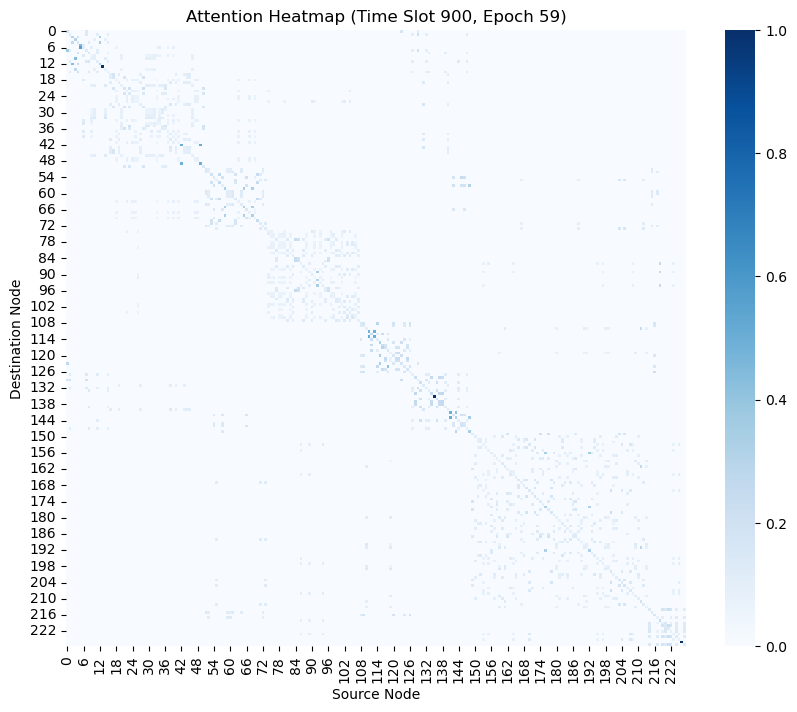

In [ ]:
time_slot = 900
visualizations.attention_matrix.plot_heatmap(attention_matrices[time_slot], epoch, time_slot)

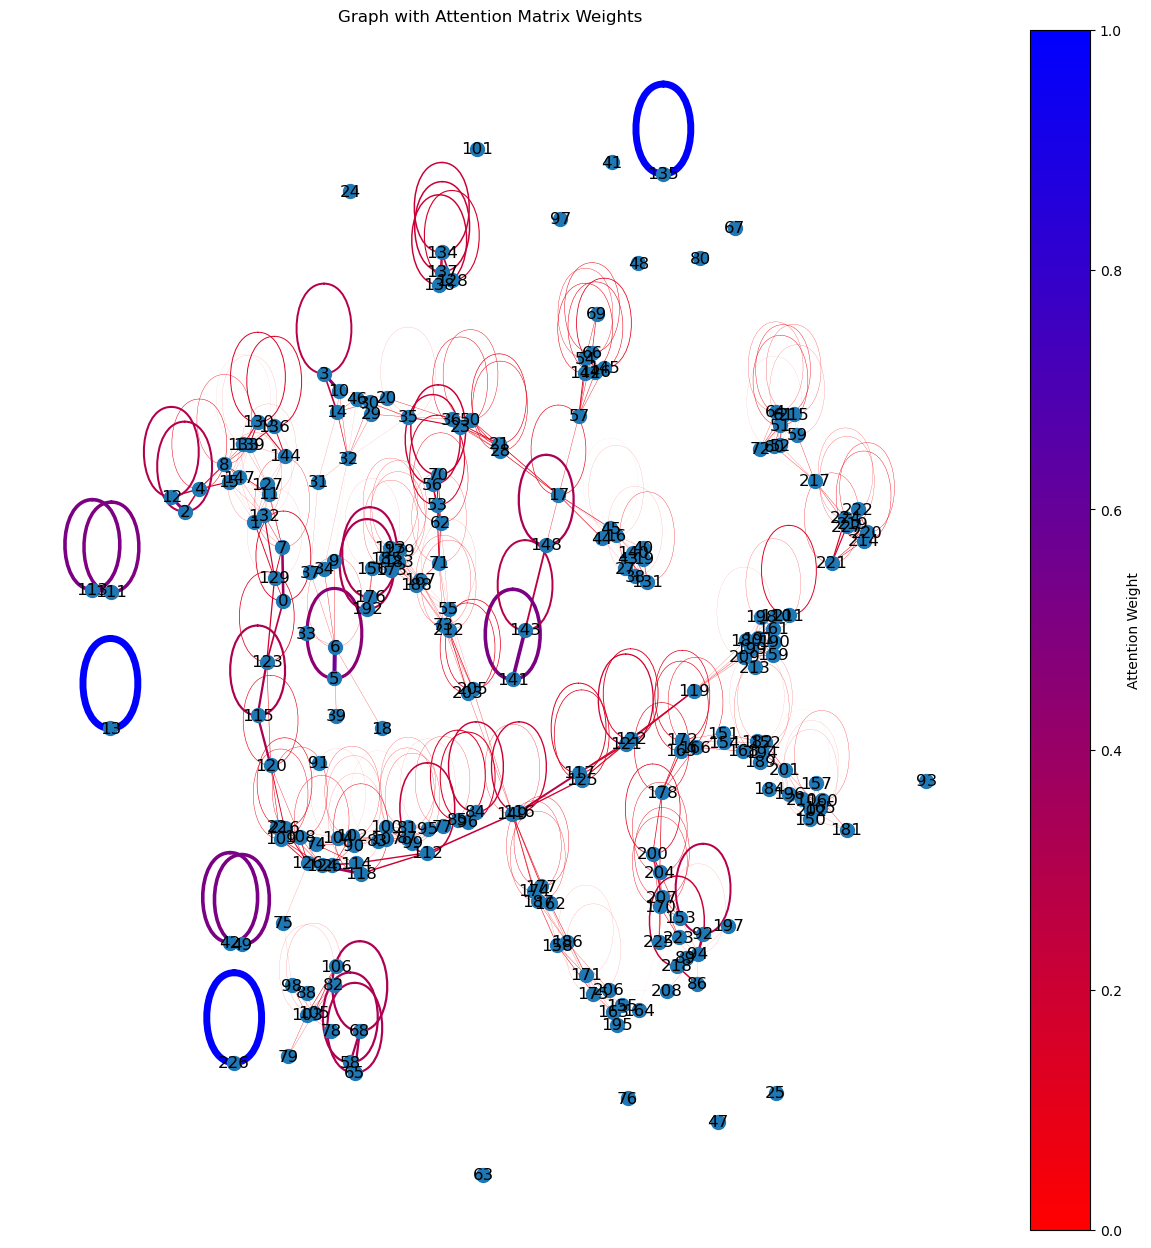

In [ ]:
import visualizations.attention_graph

importlib.reload(visualizations.attention_graph)

visualizations.attention_graph.visualize_attention_graph(attention_matrices[time_slot], threshold=0.1)

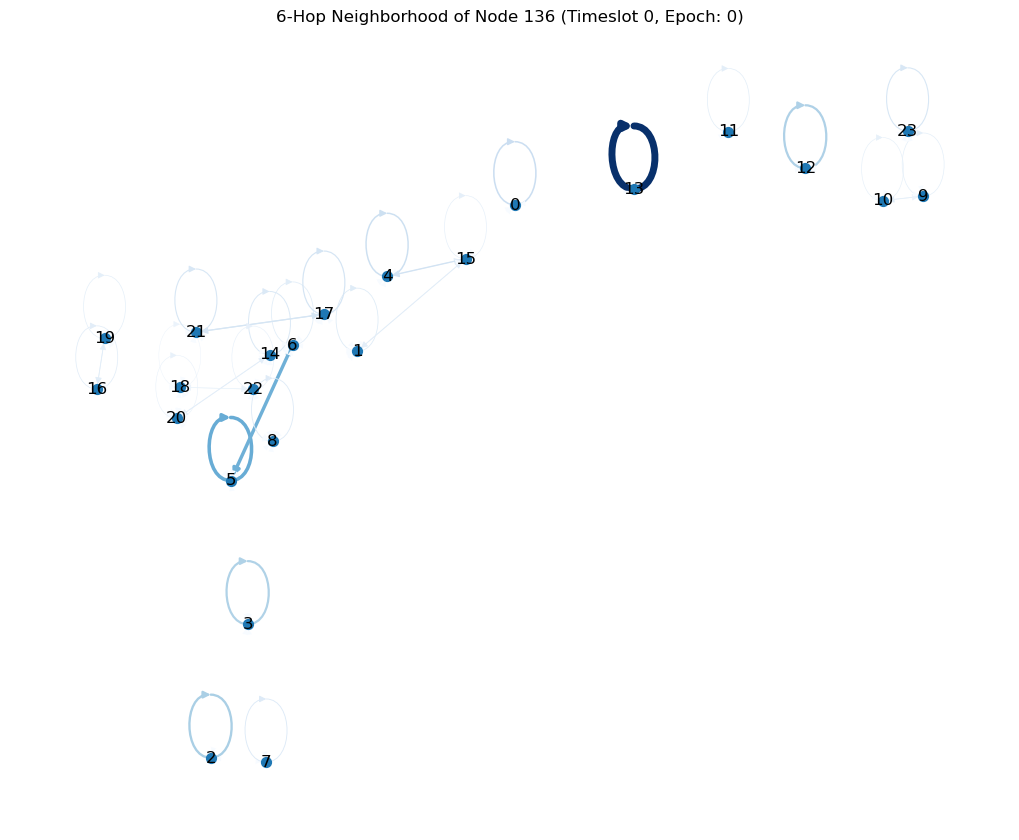

In [ ]:
importlib.reload(visualizations.attention_graph)

epoch = 0
time_slot = 0
first_epoch_first_timeslot = attn_matrices_by_batch_by_epoch[epoch][time_slot]
center_node = 136
k = 6
visualizations.attention_graph.visualize_attention_neighborhood(first_epoch_first_timeslot['batch'].cpu(), first_epoch_first_timeslot['attn'].cpu(), center_node, epoch, time_slot, k=k)

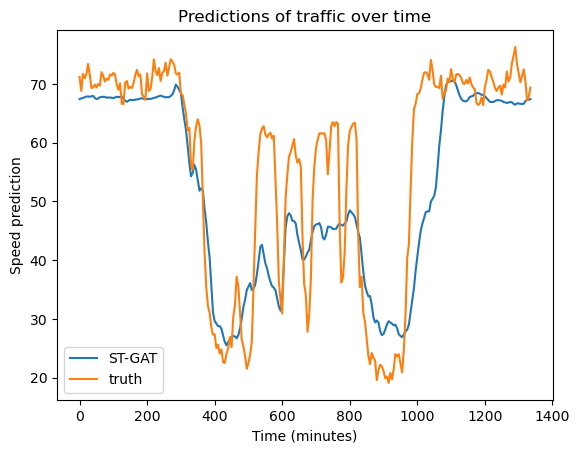

In [ ]:
import visualizations.predictions

importlib.reload(visualizations.predictions)

visualizations.predictions.plot_prediction(test_dataloader, y_pred, y_truth, 0, config)